<h1 style="text-align:center">UTS Pemrosesan dan Rekayasa Data IBDA 3311</h1>
<h2 style="text-align:center">Pembersihan Dataset Titanic dan membandingkan beberapa Model Klasifikasi</h2>
<h3 style="text-align:center">Dibuat Oleh: Stefannus Christian 202000138</h3>

# Import Data

In [1]:
import pandas as pd
import re
from prettytable import PrettyTable as pt
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
from numpy import nan
from matplotlib import pyplot
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import KFold
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import cross_val_predict
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix 
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
plt.style.use('dark_background')
from numpy import mean
from numpy import array
filterwarnings('ignore')
%matplotlib inline

# Panggil Dataset

<p style="font-size:20px">Penjelasan kolom - kolom dapat dilihat pada proposal data dan laporan</p>

In [2]:
df = pd.read_csv('./dataset/titanic_train.csv')
display(df.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Mendrop Kolom PassengerID dan Ticket & Mengganti Nama Kolom Dataset

<p style="font-size:20px">Kolom PassengerId tidak relevan terhadap dataset dan tidak ada informasi apa - apa yang dapat diperoleh dari fitur ticket</p>

In [3]:
df.drop(['PassengerId'],axis=1,inplace=True)
df.drop(['Ticket'],axis=1,inplace=True)
df.columns = ['Survived','Class','Name','Sex','Age','#Spouse','#NumParents&Kids','Fare','Cabin','Embarked']
display(df.head())

,Survived,Class,Name,Sex,Age,#Spouse,#NumParents&Kids,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,NaN,S


# Feature Engineering

## Menambah Fitur Family Size

<p style="font-size:20px">Family size adalah gabungan dari fitur jumlah spouse dan orangtua/anak yang terdapat pada kapal</p>

In [4]:
df['FamilySize'] = df['#Spouse'] + df['#NumParents&Kids'] + 1

## Mengambil Title dari nama masing - masing penumpang

In [5]:
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    return title_search.group(1) if title_search else ""

### Menambahkan kolom Title

In [6]:
df['Title'] = df['Name'].apply(get_title)
df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
df['Title'] = df['Title'].replace('Mlle', 'Miss')
df['Title'] = df['Title'].replace('Ms', 'Miss')
df['Title'] = df['Title'].replace('Mme', 'Mrs')
display(df.head())

,Survived,Class,Name,Sex,Age,#Spouse,#NumParents&Kids,Fare,Cabin,Embarked,FamilySize,Title
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,NaN,S,2,Mr
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C85,C,2,Mrs
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,NaN,S,1,Miss
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,C123,S,2,Mrs
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,NaN,S,1,Mr


### Membuang kolom nama

<p style="font-size:20px">Informasi penting yang bisa diperoleh dari nama adalah title dari penumpang sehingga kolom nama dapat dibuang setelah menambahkan kolom title</p>

In [7]:
df.drop(['Name'],axis=1,inplace=True)

## Mengelompokkan Fitur Fare menjadi 4 Kelompok

<p style="font-size:20px">Metode ini dilakukan agar kolom fare nantinya dapat di one-hot-encoding sehingga range data dari kolom ini 0 - 1 dan tidak besar sendiri seperti sebelumnya</p>

In [8]:
df['Fare'] = pd.cut(df['Fare'], bins=[0,7.91,14.45,31,120], labels=['low_fare','median_fare','average_fare','high_fare'])

# Metode Data Cleaning 1 - Membuang Data Duplikasi 

## Menampilkan Data - Data Terduplikasi

<p style="font-size:20px">Dapat dilihat dari kode dibawah bahwa terdapat <strong>194</strong> baris yang redundan / duplikat</p>

In [9]:
df[df.duplicated()]

,Survived,Class,Sex,Age,#Spouse,#NumParents&Kids,Fare,Cabin,Embarked,FamilySize,Title
32,1,3,female,NaN,0,0,low_fare,NaN,Q,1,Miss
42,0,3,male,NaN,0,0,low_fare,NaN,C,1,Mr
47,1,3,female,NaN,0,0,low_fare,NaN,Q,1,Miss
76,0,3,male,NaN,0,0,low_fare,NaN,S,1,Mr
77,0,3,male,NaN,0,0,median_fare,NaN,S,1,Mr
...,...,...,...,...,...,...,...,...,...,...,...
878,0,3,male,NaN,0,0,low_fare,NaN,S,1,Mr
881,0,3,male,33.0,0,0,low_fare,NaN,S,1,Mr
882,0,3,female,22.0,0,0,median_fare,NaN,S,1,Miss
883,0,2,male,28.0,0,0,median_fare,NaN,S,1,Mr


## Buang Data Duplikat

In [10]:
df.drop_duplicates(inplace = True)

<p style="font-size:20px">Dapat dilihat dari kode dibawah bahwa sudah tidak ada lagi data yang terduplikasi</p>

In [11]:
df[df.duplicated()]

,Survived,Class,Sex,Age,#Spouse,#NumParents&Kids,Fare,Cabin,Embarked,FamilySize,Title


# Metode Data Cleaning 2 - Imputasi Data

## Menampilkan data - data null pada dataframe

<p style="font-size:20px">Dapat dilihat dari kode dibawah bahwa, kolom - kolom yang memiliki data kosong adalah kolom age, cabin, Fare dan embarked</p>

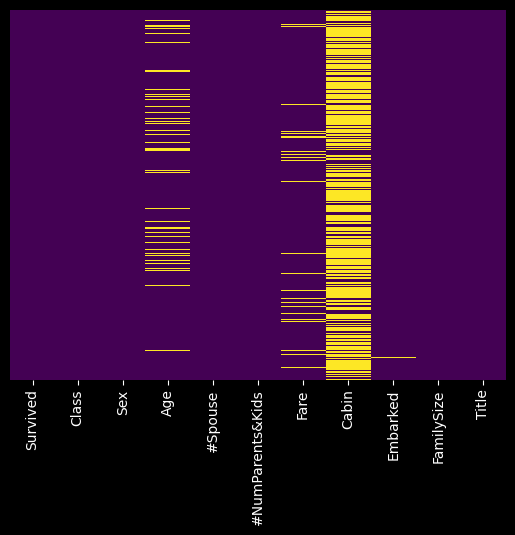

In [12]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.show()

## Drop Fitur Cabin

<p style="font-size:20px">Dapat dilihat dari kode dibawah bahwa dari total 697 Baris, 494 Baris dari Cabin (≈71%) adalah data Nan, dan tidak ada informasi yang relevan yang dapat diambil dari fitur ini sehingga lebih baik jika fitur ini dibuang saja.</p>

In [13]:
dfRow = df.shape[0]
numCabinNull = df['Cabin'].isnull().sum()
print(f'Baris Data = {dfRow}')
print(f'Number of Null Cabin Rows = {numCabinNull}')
print(f'Null Percentage = {(numCabinNull/dfRow)*100} %')

Baris Data = 697
Number of Null Cabin Rows = 494
Null Percentage = 70.8751793400287 %


In [14]:
df.drop(['Cabin'],axis=1,inplace=True)

## Imputasi Fitur Age berdasarkan Class Penumpang

### Menampilkan BoxPlot rata - rata umur penumpang berdasarkan Class

<p style="font-size:20px">1 adalah kelas bawah, 2 adalah kelas menengah, dan 3 adalah kelas atas </p>

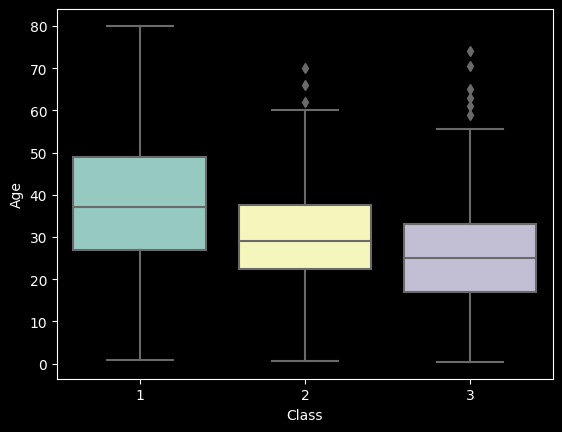

In [15]:
sns.boxplot(x='Class',y='Age',data=df)
plt.show()

### Membuat function untuk mengimputasi fitur age dengan rata-rata dari class penumpang tersebut

<p style="font-size:20px">Misalkan rata-rata dari class 1, 2, 3 adalah 35, 25,dan 20. Algoritma akan looping dataset dan mencari cell yang memiliki nilai null, jika ketemu cell yang nilai nya null, algoritma akan check class dari penumpang tersebut. Jika class dari penumpang tersebut adalah class 2, maka cell kosong tersebut akan diisi dengan rata-rata umur dari penumpang class 2 yaitu 25 (misalkan) </p>

In [16]:
# Membuat Subset dataframe yang isinya kelas penumpang dan Age untuk memudahkan 
class_age_df = df[['Class','Age']]

# Fungsi untuk mendapatkan rata - rata umur penumpang per kelas
def get_age_mean_by_class(df):
    low_class_mean = round(df[(df['Class']==1)].mean())[1]
    med_class_mean = round(df[(df['Class']==2)].mean())[1]
    high_class_mean = round(df[(df['Class']==3)].mean())[1]
    return [low_class_mean, med_class_mean, high_class_mean]

# Algoritma yang dijelaskan pada markdown diatas
def age_mean_imputation_base_on_class(age_class_df):
    # Membuat list yang isinya rata-rata umur penumpang per kelas
    age_mean_by_class = get_age_mean_by_class(class_age_df)
    Age = age_class_df[0]
    Class = age_class_df[1]
    # Jika ketemu cell yang kosong maka cell akan diimputasi berdasarkan rata-rata umur pada kelas penumpang tersebut
    if pd.isnull(Age):
        if Class == 1: return age_mean_by_class[0]
        elif Class == 2: return age_mean_by_class[1]
        else: return age_mean_by_class[2]

    # Jika tidak kosong maka return age sesungguhnya
    else: return Age

# Apply fungsi diatas pada dataframe
df['Age'] = df[['Age','Class']].apply(age_mean_imputation_base_on_class,axis=1)

#### Mengecek apakah kolom age sudah terimputasi dengan baik

<p style="font-size:20px">Dapat dilihat dari kode dibawah bahwa sudah tidak ada lagi data null pada fitur Age</p>

In [17]:
df['Age'].isnull().sum()

0

# Mengelompokkan Fitur Age menjadi 4 kelompok

<p style="font-size:20px">Sama seperti kolom fare, setelah fitur age diimputasi, fitur age dikelompokkan menjadi 4 kelompok yaitu Children, Teenange, Adult, dan Elder</p>

In [18]:
df['Age'] = pd.cut(df['Age'], bins=[0,12,20,40,120], labels=['Children','Teenage','Adult','Elder'])
display(df)

,Survived,Class,Sex,Age,#Spouse,#NumParents&Kids,Fare,Embarked,FamilySize,Title
0,0,3,male,Adult,1,0,low_fare,S,2,Mr
1,1,1,female,Adult,1,0,high_fare,C,2,Mrs
2,1,3,female,Adult,0,0,median_fare,S,1,Miss
3,1,1,female,Adult,1,0,high_fare,S,2,Mrs
4,0,3,male,Adult,0,0,median_fare,S,1,Mr
...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,Adult,0,0,median_fare,S,1,Rare
887,1,1,female,Teenage,0,0,average_fare,S,1,Miss
888,0,3,female,Adult,1,2,average_fare,S,4,Miss
889,1,1,male,Adult,0,0,average_fare,C,1,Mr


# Imputasi Kolom Embarked

<p style="font-size:20px">Dapat dilihat bahwa terdapat 2 Data Null pada fitur embarked</p>

In [19]:
df['Embarked'].isnull().sum()

2

## Imputasi Fitur Embarked menggunakan Modus

<p style="font-size:20px">Karena hanya terdapat 2 baris yang null, maka saya memutuskan untuk mengimputasi berdasarkan data terbanyak saja yaitu Southampton </p>

In [20]:
modus = df['Embarked'].mode()[0]
print(f'Modus kolom Embarked adalah {modus}')
def imputeEmbarked(x): return df['Embarked'].mode()[0] if x is nan else x
df['Embarked'] = df.Embarked.apply(imputeEmbarked)

Modus kolom Embarked adalah S


<p style="font-size:20px"></p>

# One Hote Encoding untuk data - data Kategorikal / String

<p style="font-size:20px">Karena model machine learning tidak dapat menerima data - data kategorikal berbentuk string, maka saya memustukan untuk melakukan one hot encoding menggunakan pd.get_dummies untuk fitur - fitur Sex, Title, Age, Embarked, dan Fare</p>  

## Membuat Dummy Dataframe dengan fitur - fitur Sex, Title, Age, Embarked, dan Fare

In [21]:
dummyDf = pd.get_dummies(df, columns = ["Sex","Title","Age","Embarked","Fare"],drop_first=True)
display(dummyDf.head())

,Survived,Class,#Spouse,#NumParents&Kids,FamilySize,Sex_male,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Age_Teenage,Age_Adult,Age_Elder,Embarked_Q,Embarked_S,Fare_median_fare,Fare_average_fare,Fare_high_fare
0,0,3,1,0,2,1,0,1,0,0,0,1,0,0,1,0,0,0
1,1,1,1,0,2,0,0,0,1,0,0,1,0,0,0,0,0,1
2,1,3,0,0,1,0,1,0,0,0,0,1,0,0,1,1,0,0
3,1,1,1,0,2,0,0,0,1,0,0,1,0,0,1,0,0,1
4,0,3,0,0,1,1,0,1,0,0,0,1,0,0,1,1,0,0


## Membuang fitur - fitur Sex, Title, Age, Embarked, dan Fare

<p style="font-size:20px">Fitur - Fitur ini didrop karena sudah ada representasi one hot encoding yang telah dibuat oleh dummyDf pada cell kode diatas</p>

In [22]:
df.drop(["Sex","Title","Age","Embarked","Fare"],axis=1,inplace=True)

## Menambahkan dummy Dataframe ke Dataframe Utama

In [23]:
df = pd.concat([dummyDf],axis=1)

# Menampilkan DataFrame setelah dilakukan one hot encoding

In [24]:
display(df.head())

,Survived,Class,#Spouse,#NumParents&Kids,FamilySize,Sex_male,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Age_Teenage,Age_Adult,Age_Elder,Embarked_Q,Embarked_S,Fare_median_fare,Fare_average_fare,Fare_high_fare
0,0,3,1,0,2,1,0,1,0,0,0,1,0,0,1,0,0,0
1,1,1,1,0,2,0,0,0,1,0,0,1,0,0,0,0,0,1
2,1,3,0,0,1,0,1,0,0,0,0,1,0,0,1,1,0,0
3,1,1,1,0,2,0,0,0,1,0,0,1,0,0,1,0,0,1
4,0,3,0,0,1,1,0,1,0,0,0,1,0,0,1,1,0,0


## Summary dari DataFrame

In [25]:
df.describe()

,Survived,Class,#Spouse,#NumParents&Kids,FamilySize,Sex_male,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Age_Teenage,Age_Adult,Age_Elder,Embarked_Q,Embarked_S,Fare_median_fare,Fare_average_fare,Fare_high_fare
count,697.000000,697.000000,697.000000,697.000000,697.000000,697.000000,697.000000,697.000000,697.000000,697.000000,697.000000,697.000000,697.000000,697.000000,697.000000,697.000000,697.000000,697.000000
mean,0.449067,2.166428,0.595409,0.470588,2.065997,0.592539,0.226686,0.507891,0.176471,0.032999,0.126255,0.566714,0.209469,0.061693,0.721664,0.222382,0.298422,0.255380
std,0.497756,0.864942,1.065327,0.875634,1.607706,0.491715,0.418988,0.500297,0.381494,0.178761,0.332375,0.495885,0.407222,0.240770,0.448501,0.416145,0.457894,0.436388
min,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,2.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,3.000000,1.000000,1.000000,3.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000
max,1.000000,3.000000,8.000000,6.000000,11.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Mengecek tipe data dari semua fitur

<p style="font-size:20px">Machine Learning model tidak dapat mengerti data - data kategorikal berbentuk string atau object sehingga perlu dipastikan bahwa seluruh fitur adalah dalam bentuk integer/float. Dapat dilihat dari kode dibawah bahwa seluruh dataset sudah dalam bentuk integer</p>

In [26]:
print(df.dtypes)

Survived             int64
Class                int64
#Spouse              int64
#NumParents&Kids     int64
FamilySize           int64
Sex_male             uint8
Title_Miss           uint8
Title_Mr             uint8
Title_Mrs            uint8
Title_Rare           uint8
Age_Teenage          uint8
Age_Adult            uint8
Age_Elder            uint8
Embarked_Q           uint8
Embarked_S           uint8
Fare_median_fare     uint8
Fare_average_fare    uint8
Fare_high_fare       uint8
dtype: object


# Menampilkan Matrix Korelasi

<p style="font-size:20px">KORELASI POSITIF: Jika peningkatan fitur A menyebabkan peningkatan fitur B, maka mereka berkorelasi positif. Nilai 1 berarti korelasi positif sempurna. </p>
<p style="font-size:20px">KORELASI NEGATIF: Jika peningkatan fitur A menyebabkan penurunan fitur B, maka mereka berkorelasi negatif. Nilai -1 berarti korelasi negatif sempurna.
</p>

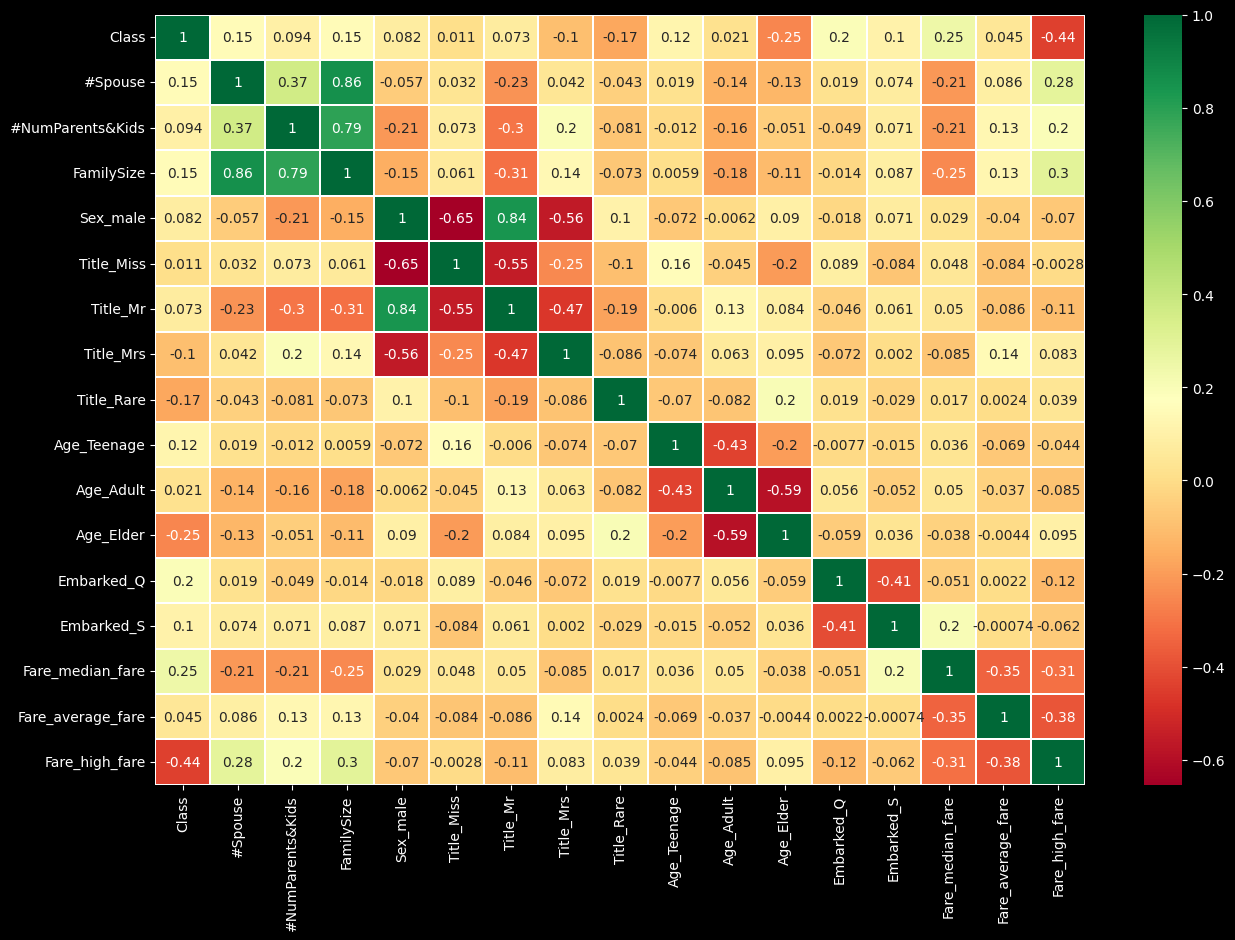

In [27]:
sns.heatmap(df.iloc[:,1:].corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig = plt.gcf()
fig.set_size_inches(15,10)
plt.show()

# RFE Feature Selection (Metode Feature Selection 1)

## Membuat Fungsi get_dataset dan evaluate_model

In [28]:
# membuat fungsi untuk membagi dataset menjadi input dan output
def get_dataset(df):
	X = df.iloc[:,1:]
	y = df.iloc[:,0]
	return X, y

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores

## Menggunakan Model Logistic Regression untuk membandingkan 5 estimator RFE yaitu Logistic Regression, Perceptron, Decision Tree, Random Forest, dan Gradient Boosting

In [29]:
def get_logreg_models(df,X,y):
	# membuat variabel models list untuk menyimpan hasil pelatihan dari model - model
	models_list = []
	# menyimpan model dalam dictionary yang nantinya akan dikumpulkan pada variabel model_list
	models = {}
	# membuat variabel supportRanking untuk menyimpan hasil Ranking
	supportRanking = []
	# Iterasi dari 2 num features untuk dipilih sampai dengan jumlah kolom dari dataset
	for numFeatures in range(2,df.shape[1]+1):
		# lr
		rfe = RFE(estimator=LogisticRegression(), n_features_to_select=numFeatures)
		model = LogisticRegression()
		models[f'lr{-numFeatures}'] = Pipeline(steps=[('s',rfe),('m',model)])
		rfe.fit(X,y)
		supportRanking.append([rfe.support_,rfe.ranking_])
		models_list.append(models)

		# perceptron
		rfe = RFE(estimator=Perceptron(), n_features_to_select=numFeatures)
		rfe.fit(X,y)
		supportRanking.append([rfe.support_,rfe.ranking_])
		model = LogisticRegression()
		models[f'per{-numFeatures}'] = Pipeline(steps=[('s',rfe),('m',model)])
		models_list.append(models)

		# cart
		rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=numFeatures)
		rfe.fit(X,y)
		supportRanking.append([rfe.support_,rfe.ranking_])
		model = LogisticRegression()
		models[f'cart{-numFeatures}'] = Pipeline(steps=[('s',rfe),('m',model)])
		models_list.append(models)

		# rf
		rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=numFeatures)
		rfe.fit(X,y)
		supportRanking.append([rfe.support_,rfe.ranking_])
		model = LogisticRegression()
		models[f'rf{-numFeatures}'] = Pipeline(steps=[('s',rfe),('m',model)])
		models_list.append(models)
		
		# gbm
		rfe = RFE(estimator=GradientBoostingClassifier(), n_features_to_select=numFeatures)
		rfe.fit(X,y)
		supportRanking.append([rfe.support_,rfe.ranking_])
		model = LogisticRegression()
		models[f'gbm{-numFeatures}'] = Pipeline(steps=[('s',rfe),('m',model)])
		models_list.append(models)
	return models,supportRanking

# Hasil dari kode diatas akan disimpan dengan menjalankan fungsi dibawah ini
def getFinalResults(X,y,theModel):
    finalResults = {}
    for rfeEstimator,models in zip(theModel.keys(),theModel.values()):
        results, names = [],[]
        for model in models:
            scores = evaluate_model(model, X, y)
            results.append(scores)
            finalResults[rfeEstimator] = mean(results)
    return finalResults

## Mencari estimator terbaik beserta dengan Jumlah Fitur terbarik

In [30]:
# Fungsi untuk mendapatkan key dictionary jika diketahui value nya
def getDictKeyFromValue(d:dict,value):
    keys = [k for k, v in d.items() if v == value]
    return keys

# Fungsi untuk mendapatkan Estimator terbaik beserta dengan jumlah fitur nya
def getBestRFEEstimatorWithNumFeatures(finalResults:dict):
    output = []
    allAverage = finalResults.values()
    bestEstimator = max(allAverage)
    estimatorName = getDictKeyFromValue(finalResults,bestEstimator)
    output.append(estimatorName)
    output.append(bestEstimator)
    return output

# Fungsi untuk print Estimator terbaik beserta dengan jumlah fitur nya dan akurasi yang dihasilkan jika menggunakan estimator tersebut dengan jumlah fitur yang dipilih
def printBestRFEEstimatorWithNumFeaturesName(bestRFEEstimator,model):
    translateAbbreviation = {'lr':'Logistic Regression','per':'Perceptron','cart':'Decision Tree','rf':'Random Forest','gbm':
        'Gradient Boosting'}
    theEstimator = bestRFEEstimator[0][0]
    stripIndex = theEstimator.index('-')
    theEstimatorFull = translateAbbreviation[theEstimator[:stripIndex]]
    theAccuracy = bestRFEEstimator[1]
    numFeatures = theEstimator[stripIndex+1:]
    print(f'RFE Estimator terbaik untuk model {model} adalah {theEstimatorFull} dengan {numFeatures} jumlah fitur.')
    print(f'Akurasi = {(theAccuracy*100)}%')

# Mendapatkan index dari jumlah feature terbaik  
def getNumFeaturesWithIndex(theModel,bestEstimatorLogReg):
    keyList = list(theModel.keys())
    theIndex = keyList.index(bestEstimatorLogReg[0][0])
    return theIndex

# Mendapatkan semua fitur pilihan yang diambil dari estimator dan numFeatures terbaik
def getSelectedFeatures(theModel,bestEstimator,rfeSupport):
    theSelectedEstimatorIndex = getNumFeaturesWithIndex(theModel,bestEstimator)
    selectedFeaturesList = rfeSupport[theSelectedEstimatorIndex][0]
    selectedFeatures = []
    for i in range(len(selectedFeaturesList)):
        if selectedFeaturesList[i]: selectedFeatures.append(i+1)
    selectedFeatures = [0] + selectedFeatures
    return selectedFeatures

In [31]:
# define dataset
X, y = get_dataset(df)

### Menampilkan hasil dari fungsi get_logreg_models yang output nya adalah estimator-{jumlah fitur}:{akurasi}

In [32]:
logisticRegressionModel,rfeSupport = get_logreg_models(df,X,y)
modelName = 'Logistic Regression'
print(f'{modelName} Model')
logregResults = getFinalResults(X,y,logisticRegressionModel)
print(logregResults)

Logistic Regression Model
{'lr-2': 0.7611732229123531, 'per-2': 0.6896342305037957, 'cart-2': 0.7702415458937197, 'rf-2': 0.7611525189786058, 'gbm-2': 0.7702415458937197, 'lr-3': 0.7609420289855071, 'per-3': 0.7019841269841269, 'cart-3': 0.7618771566597652, 'rf-3': 0.7664078674948239, 'gbm-3': 0.7597308488612835, 'lr-4': 0.7649896480331262, 'per-4': 0.7182988267770875, 'cart-4': 0.7635714285714285, 'rf-4': 0.7726501035196686, 'gbm-4': 0.7786093857832986, 'lr-5': 0.7642408557625947, 'per-5': 0.7274568668046927, 'cart-5': 0.7673844030365768, 'rf-5': 0.7690648723257418, 'gbm-5': 0.7767115251897859, 'lr-6': 0.7642546583850931, 'per-6': 0.7257142857142856, 'cart-6': 0.7595100069013111, 'rf-6': 0.7671325051759833, 'gbm-6': 0.7767115251897859, 'lr-7': 0.7654485852311939, 'per-7': 0.7329675638371289, 'cart-7': 0.7611559696342304, 'rf-7': 0.7728812974465148, 'gbm-7': 0.7771808143547273, 'lr-8': 0.7673809523809523, 'per-8': 0.7285955831608005, 'cart-8': 0.7628467908902691, 'rf-8': 0.778126293995

### Menampilkan Estimator terbaik beserta jumlah fitur nya

In [33]:
bestEstimatorLogReg = getBestRFEEstimatorWithNumFeatures(logregResults)
printBestRFEEstimatorWithNumFeaturesName(bestEstimatorLogReg,modelName)

RFE Estimator terbaik untuk model Logistic Regression adalah Gradient Boosting dengan 11 jumlah fitur.
Akurasi = 78.05003450655623%


## Membuat Dataframe newDfRFE yang isinya adalah fitur-fitur yang dipilih oleh Estimator Logistic Regression dengan 13 jumlah fitur input dan 1 fitur output

In [34]:
selectedFeatures = getSelectedFeatures(logisticRegressionModel,bestEstimatorLogReg,rfeSupport)
newDfRFE = df.iloc[:,selectedFeatures]
newDfRFE

,Survived,Class,#Spouse,FamilySize,Sex_male,Title_Mr,Title_Rare,Age_Adult,Age_Elder,Embarked_S,Fare_median_fare,Fare_average_fare
0,0,3,1,2,1,1,0,1,0,1,0,0
1,1,1,1,2,0,0,0,1,0,0,0,0
2,1,3,0,1,0,0,0,1,0,1,1,0
3,1,1,1,2,0,0,0,1,0,1,0,0
4,0,3,0,1,1,1,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,0,1,1,0,1,1,0,1,1,0
887,1,1,0,1,0,0,0,0,0,1,0,1
888,0,3,1,4,0,0,0,1,0,1,0,1
889,1,1,0,1,1,1,0,1,0,0,0,1


# Training Model - Model Machine Learning (Logistic Regression, KNN, SVM, Naive-Bayes, Decision Tree, Random Forest, Linear Discriminant Analysis, Ada Boost, dan Gradient Boosting)

## Membuat fungsi untuk membandingkan skor akurasi model dan cross val score sebelum dilakukan feature selection dan setelah dilakukan feature selection

In [35]:
def trainModelandCompare(df,dfAfterFeatureSelection,modelName:list,models:list,featureSelectionMethod: str):
    accuracyList = []
    crossValScoreList = []
    accuracyListAfter = []
    crossValScoreListAfter = []
    for (_model,name) in zip(models,modelName):
        
        # Before Feature Selection Model
        X,y = get_dataset(df)
        X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state=42)
        model = _model
        model.fit(X_train,y_train)
        prediction_lr = model.predict(X_test)
        modelAccuracy = accuracy_score(prediction_lr,y_test)*100
        accuracyList.append(modelAccuracy)
        kfold = KFold(n_splits=10)
        result_lr = cross_val_score(model,X,y,cv=10,scoring='accuracy')
        crossValScore = result_lr.mean()*100
        crossValScoreList.append(crossValScore)

        # After Feature Selection Model

        X,y = get_dataset(dfAfterFeatureSelection)
        X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state=42)
        model = _model
        model.fit(X_train,y_train)
        prediction_lr = model.predict(X_test)
        modelAccuracy = accuracy_score(prediction_lr,y_test)*100
        accuracyListAfter.append(modelAccuracy)
        kfold = KFold(n_splits=10)
        result_lr = cross_val_score(model,X,y,cv=10,scoring='accuracy')
        crossValScore = result_lr.mean()*100
        crossValScoreListAfter.append(crossValScore)

    return accuracyList,accuracyListAfter,crossValScoreList,crossValScoreListAfter

# Membuat tabel perbandingan performa berbagai model setelah dan sebelom feature selection 

In [36]:
modelNames = ['Logistic Regression','KNN','SVM','Naive-Bayes','Decision Tree','RandomForest','Linear Discriminant Analysis','Ada Boost','Gradient Boosting']
models = [LogisticRegression(),KNeighborsClassifier(n_neighbors = 4),SVC(),GaussianNB(),DecisionTreeClassifier(criterion='gini', min_samples_split=10,min_samples_leaf=1,max_features='auto'),RandomForestClassifier(criterion='gini', n_estimators=700 ,min_samples_split=10,min_samples_leaf=1,max_features='auto',oob_score=True,random_state=1,n_jobs=-1),LinearDiscriminantAnalysis(),AdaBoostClassifier(),GradientBoostingClassifier()]

In [37]:
# Fungsi untuk membulatkan score akurasi menjadi 3 desimal dibelakang koma
def roundScore(l:list): return [round(i,3) for i in l]

# Fungsi untuk membuat tabel perbandingan
def makeTable(modelNames:list,accuracyList,accuracyListAfter,crossValScore,crossValScoreAfter,featureSelectionMethod):
    comparisonTable = pt()
    comparisonTable.title = f'Tabel Komparasi {featureSelectionMethod} Feature Selection'
    comparisonTable.field_names = ["No","Model", "Akurasi (FS❌)", "Akurasi (FS✅)","CrossVal Score (FS❌) ","CrossVal Score(FS✅)"]
    n = len(modelNames)
    accuracyList = roundScore(accuracyList)
    accuracyListAfter = roundScore(accuracyListAfter)
    crossValScore = roundScore(crossValScore)
    crossValScoreAfter = roundScore(crossValScoreAfter)
    for i in range(n): comparisonTable.add_row((i+1,modelNames[i],str(accuracyList[i])+' %',str(accuracyListAfter[i])+' %',str(crossValScore[i])+' %',str(crossValScoreAfter[i])+' %'))
    return comparisonTable

# Fungsi untuk mendeteksi apakah terdapat kenaikan akurasi sebelum dan sesudah seleksi fitur
def detectAccuracyImprovement(modelNamesList,accuracyList,accuracyListAfter):
    modelName,theAccuracy,theAccuracyAfter = [],[],[]
    index = 0
    for before,after in zip(accuracyList,accuracyListAfter):
        if after >= before: 
            modelName.append(modelNamesList[index])
            theAccuracy.append(before)
            theAccuracyAfter.append(after)
            index+=1 
    return modelName,theAccuracy,theAccuracyAfter

# Membuat tabel untuk menampilkan model - model yang memiliki kenaikkan akurasi 
def improveModelsTablesAccuracy(featureSelectionMethod:str,modelName:list, accuracy:list,accuracyAfter:list):
    table = pt()
    table.title = f'Model yang memiliki improvement akurasi setelah {featureSelectionMethod} feature selection'
    table.field_names = ["No","Model", "Akurasi (FS❌)", "Akurasi (FS✅)"]
    n = len(modelName)
    accuracy = roundScore(accuracy)
    accuracyAfter = roundScore(accuracyAfter)
    for i in range(n): table.add_row((i+1,modelName[i],str(accuracy[i])+' %',str(accuracyAfter[i])+' %'))
    return table

# Fungsi untuk mendeteksi apakah terdapat penurunan akurasi sebelum dan sesudah seleksi fitur
def detectAccuracyDownGrade(modelNamesList,accuracyList,accuracyListAfter):
    betterModels,beforeAccuracy, afterAccuracy = detectAccuracyImprovement(modelNamesList,accuracyList,accuracyListAfter)
    worstModelsName = []
    theAccuracyBefore = []
    theAccuracyAfter = []
    for model_name,accuracy,accuracy_after in zip(modelNamesList,accuracyList,accuracyListAfter):
        if model_name not in betterModels:
            worstModelsName.append(model_name)
            theAccuracyBefore.append(accuracy)
            theAccuracyAfter.append(accuracy_after)
    return worstModelsName, theAccuracyBefore, theAccuracyAfter


# Membuat tabel untuk menampilkan model - model yang memiliki penurunan akurasi 
def worstModelsTablesAccuracy(featureSelectionMethod:str,modelName:list, accuracy:list,accuracyAfter:list):
    table = pt()
    table.title = f'Model yang memiliki penurunan akurasi setelah {featureSelectionMethod} feature selection'
    table.field_names = ["No","Model", "Akurasi (FS❌)", "Akurasi (FS✅)"]
    n = len(modelName)
    accuracy = roundScore(accuracy)
    accuracyAfter = roundScore(accuracyAfter)
    for i in range(n): table.add_row((i+1,modelName[i],str(accuracy[i])+' %',str(accuracyAfter[i])+' %'))
    return table

In [38]:
accuracyList,accuracyListAfter,crossValScore,crossValScoreAfter = trainModelandCompare(df,newDfRFE,modelNames,models,'RFE')

In [39]:
tabel = makeTable(modelNames,accuracyList,accuracyListAfter,crossValScore,crossValScoreAfter,'RFE')
print(tabel)

+---------------------------------------------------------------------------------------------------------------------+
|                                        Tabel Komparasi RFE Feature Selection                                        |
+----+------------------------------+----------------+----------------+------------------------+----------------------+
| No |            Model             | Akurasi (FS❌) | Akurasi (FS✅) | CrossVal Score (FS❌)  | CrossVal Score(FS✅) |
+----+------------------------------+----------------+----------------+------------------------+----------------------+
| 1  |     Logistic Regression      |    80.476 %    |    78.571 %    |        78.062 %        |       77.342 %       |
| 2  |             KNN              |    75.714 %    |    79.524 %    |        75.605 %        |       75.47 %        |
| 3  |             SVM              |    80.476 %    |    81.429 %    |        79.056 %        |       79.201 %       |
| 4  |         Naive-Bayes          |    78.

In [40]:
betterModelName,beforeAccuracy,afterAccuracy = detectAccuracyImprovement(modelNames,accuracyList,accuracyListAfter)
betterModelTable = improveModelsTablesAccuracy('RFE',betterModelName,beforeAccuracy,afterAccuracy)
print(betterModelTable) 
worstModelName, beforeAccuracyWorst, afterAccuracyWorst = detectAccuracyDownGrade(modelNames,accuracyList,accuracyListAfter)
worstModelTable = worstModelsTablesAccuracy('RFE',worstModelName,beforeAccuracyWorst,afterAccuracyWorst)
print(worstModelTable)

+-----------------------------------------------------------------------------+
|    Model yang memiliki improvement akurasi setelah RFE feature selection    |
+-----+---------------------------------+------------------+------------------+
|  No |              Model              |  Akurasi (FS❌)  |  Akurasi (FS✅)  |
+-----+---------------------------------+------------------+------------------+
|  1  |       Logistic Regression       |     75.714 %     |     79.524 %     |
|  2  |               KNN               |     80.476 %     |     81.429 %     |
|  3  |               SVM               |     78.571 %     |     80.952 %     |
|  4  |           Naive-Bayes           |     77.619 %     |     79.524 %     |
|  5  |          Decision Tree          |     79.524 %     |     80.952 %     |
|  6  |           RandomForest          |      80.0 %      |     80.476 %     |
|  7  |   Linear Discriminant Analysis  |     78.571 %     |      80.0 %      |
+-----+---------------------------------+-

# Mutual Information Feature Selection (Metode Feature Selection 2)

<p style="font-size:20px">Dapat dilihat dari hasil RFE Feauture Selection bahwa model SVM memiliki akurasi terbaik setelah dilakukan RFE Feature Selection, maka dari itu, saya akan menggunakan model SVM</p>

In [41]:
X,y = get_dataset(df)

In [42]:
# mutual information feature selection 
def select_features(X_train, y_train, X_test,k):
	fs = SelectKBest(score_func=mutual_info_classif, k=k)
	fs.fit(X_train, y_train)
	X_train_fs = fs.transform(X_train)
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs

## Mencari jumlah fitur terbaik

<p style="font-size:20px">Saya mengiterasi seluruh k dari 1 - 17 dan mencari mana hasil k yang menghasilkan akurasi tertinggi, itulah k yang akan diambil. ,<br>k = jumlah fitur</p>

k = k artinya k fitur terbaik diambil
Accuracy k = 1: 72.38 %
Accuracy k = 2: 58.1 %
Accuracy k = 3: 67.62 %
Accuracy k = 4: 50.95 %
Accuracy k = 5: 78.57 %
Accuracy k = 6: 76.67 %
Accuracy k = 7: 80.0 %
Accuracy k = 8: 74.76 %
Accuracy k = 9: 76.67 %
Accuracy k = 10: 79.05 %
Accuracy k = 11: 73.33 %
Accuracy k = 12: 78.1 %
Accuracy k = 13: 78.57 %
Accuracy k = 14: 78.57 %
Accuracy k = 15: 79.05 %
Accuracy k = 16: 76.67 %
Accuracy k = 17: 75.71 %


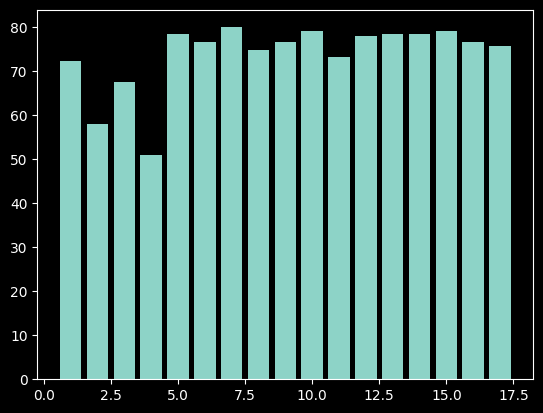

In [48]:
# kList isinya adalah pilihan fitur dari 1 - 17
kList = [i for i in range(1,X.shape[1]+1)]
# membuat accList untuk menyimpan hasil akurasi masing - masing pilihan fitur
accList = []
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print('k = k artinya k fitur terbaik diambil')
for k in kList:
	X_train_fs, X_test_fs = select_features(X_train, y_train, X_test,k)
	model = KNeighborsClassifier(n_neighbors=4)
	model.fit(X_train_fs, y_train)
	# evaluate the model
	yhat = model.predict(X_test_fs)
	# evaluate predictions
	accuracy = accuracy_score(y_test, yhat)*100
	accList.append(accuracy)
	print(f'Accuracy k = {k}: {round(accuracy,2)} %')
pyplot.bar(kList, accList)
pyplot.show()

## Memperlihatkan k terbaik dan akurasinya

<p style="font-size:20px">Dapat dilihat bahwa k terbaik adalah 15 dengan akurasi ≈81.429 %</p>

In [49]:
def getBestK(kList,accList):
    kDict = {acc:k for k,acc in zip(kList,accList)}
    bestK = kDict[max(accList)]
    theAcc = getDictKeyFromValue(kDict,bestK)[0]
    theAcc = round(theAcc,3)
    print(f'Akurasi terbaik adalah {theAcc} % ketika mengambil {bestK} fitur terbaik.')
    return bestK
getBestK(kList,accList)

Akurasi terbaik adalah 80.0 % ketika mengambil 7 fitur terbaik.


7

In [50]:
X,y = get_dataset(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [51]:
# mutual information best feature selection 
def select_best_features(X_train, y_train, X_test,bestK):
	fs = SelectKBest(score_func=mutual_info_classif, k=bestK)
	fs.fit(X_train, y_train)
	X_train_fs = fs.transform(X_train)
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs

In [52]:
bestK = getBestK(kList,accList)
X_train_fs, X_test_fs = select_best_features(X_train, y_train, X_test,15)
X_train_fs = pd.DataFrame(X_train_fs)
display(X_train_fs.head())

Akurasi terbaik adalah 80.0 % ketika mengambil 7 fitur terbaik.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,3,1,1,3,0,0,0,1,0,0,0,1,1,0,0
1,3,0,0,1,1,0,1,0,0,0,1,0,0,0,0
2,3,2,0,3,1,0,1,0,0,0,0,1,0,1,0
3,1,0,0,1,1,0,1,0,0,0,0,0,0,1,0
4,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0
